In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import src.io as sio
import src.preprocessing as spp
import src.fitting as sft

# Using .matplollibrc in folder

In [2]:
AFM_FOLDER = "../data/20200818_Akiyama_AFM/"

In [3]:
df = sio.read_dat(AFM_FOLDER + "frq-sweep001.dat")
freq_shift = df["Frequency Shift (Hz)"]
amplitude = df["Amplitude (m)"]
phase = df["Phase (deg)"]
fano = sft.fit_fano(freq_shift, amplitude)
lorentzian = sft.fit_lorentzian(freq_shift, phase, linear_offset=False)

<IPython.core.display.Javascript object>


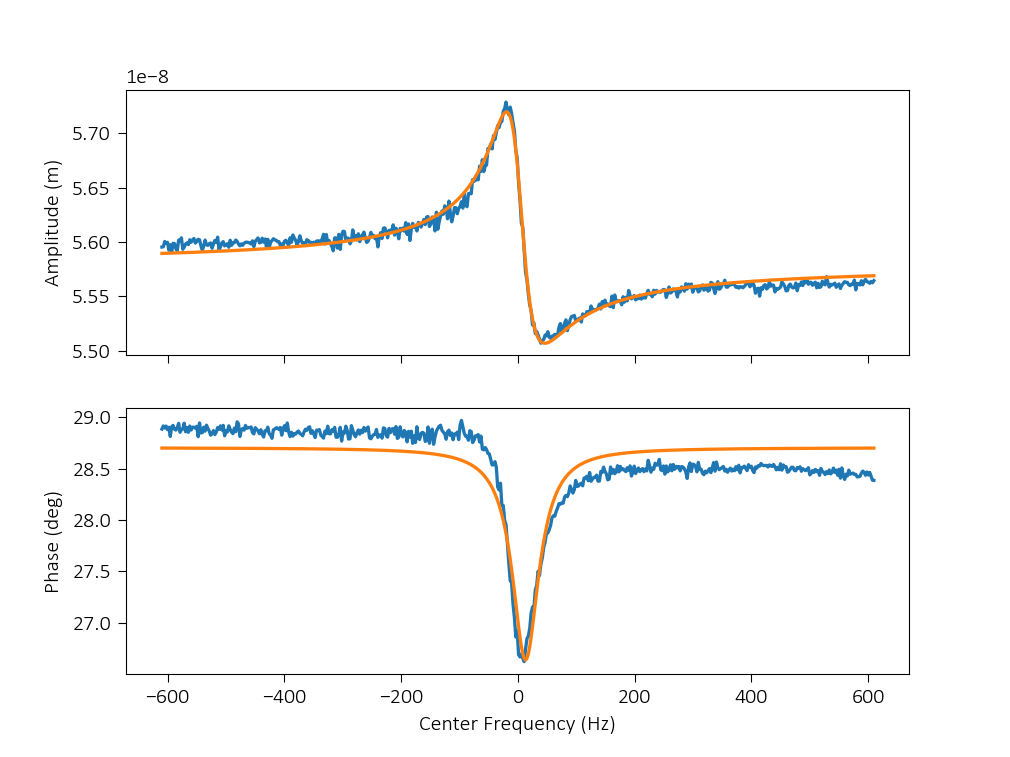

Text(0.5, 0, 'Center Frequency (Hz)')

In [4]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(freq_shift, amplitude)
ax1.plot(freq_shift, fano.best_fit)
ax1.set_ylabel(df.columns[2])

ax2.plot(freq_shift, phase)
ax2.plot(freq_shift, lorentzian.best_fit)
ax2.set_ylabel(df.columns[3])
ax2.set_xlabel(df.columns[1])

In [5]:
fano

In [6]:
lorentzian